In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import rasterio
import sqlite3
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
import numpy.ma as ma

weatherData.npy and localizationData.npy used np.any(inputData0==-9999.), so were missing the borders

FullweatherData.npy and FullLocData.npy used np.all(inputData0==-9999.), so they have all of the contiguous US.

In [62]:
nx, ny = 140, 62
ybin = np.linspace(0,621,ny, dtype=int)
xbin = np.linspace(0,1405,nx, dtype=int)
ds = rasterio.open('PRISMdaily\PRISM_ppt_stable_4kmD2_19920101_bil.bil')
affine = ds.affine
data = ds.read(1)
latbin = ybin*affine[4]+affine[5]
longbin = xbin*affine[0]+affine[2]
loc = []
for ix in range(nx-1):
    for iy in range(ny-1):
        # Verify we have a full cell.
        inputData0 = data[ybin[iy]:ybin[iy+1],xbin[ix]:xbin[ix+1]]
        if np.all(inputData0==-9999.):
            continue
        loc.append((ix, iy))
loc = np.array(loc)

np.save('FullLocData', loc, allow_pickle=True, fix_imports=False)

loc.shape

(4925, 2)

In [2]:
# !!!! IMPORTANT: Next time, do an implementation that start with np.empty so that I can fill one array
# without needing to copy it.

# Do not reevaluate!!! I have the weather data for 8 years.

# 2000 is not done yet. So nyear <= 8
nyear = 8 # Up to 24
nleapday = 2 # Up to 6

# Split data into region of latitude and longitude.
nx, ny = 140, 62 # Need to be the same as when I produced LocalizationData.npy
ybin = np.linspace(0,621,ny, dtype=int)
xbin = np.linspace(0,1405,nx, dtype=int)
loc = np.load('FullLocData.npy') # Shape: 4925 xy bins, 2 channel. Integer value
print(loc.shape)

# day
nday0 = [31,28,31,30,31,30,31,31,30,31,30,31]
nday1 = [31,29,31,30,31,30,31,31,30,31,30,31]
def nday(year,month):
    if year%4 == 0:
        return nday1[month-1]+1
    else:
        return nday0[month-1]+1

# Prepare input data
weatherData = []
for year in range(1992,1992+nyear):
  for month in range(1,13):
    for day in range(1,nday(year,month)):
        ds1 = rasterio.open('PRISMdaily\PRISM_ppt_stable_4kmD2_'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'_bil.bil')
        ds2 = rasterio.open('PRISMdaily\PRISM_tmax_stable_4kmD1_'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'_bil.bil')
        ds3 = rasterio.open('PRISMdaily\PRISM_tmean_stable_4kmD1_'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'_bil.bil')
        ds4 = rasterio.open('PRISMdaily\PRISM_tmin_stable_4kmD1_'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'_bil.bil')
        data = np.array([ds1.read(1),ds2.read(1),ds3.read(1),ds4.read(1)])
        weatherDataT=[]
        for ix, iy in loc:
            weatherDataT.append(np.mean(ma.masked_equal(data[:,ybin[iy]:ybin[iy+1],xbin[ix]:xbin[ix+1]],-9999.),axis=(1,2)))
        weatherData.append(weatherDataT)
weatherData = np.array(weatherData)

(4925, 2)


MemoryError: 

In [8]:
weatherData = np.array(weatherData)

In [7]:
print(len(weatherData),
len(weatherData[0]),
len(weatherData[0][0]))

2922 4925 4


In [9]:
# Save weather data for future use
np.save('FullweatherData', weatherData, allow_pickle=True, fix_imports=False)

In [2]:
# Load weather data
weatherData = np.load('FullweatherData.npy')  # Shape: 4389 xy bins, 365 years, 4 input channel. Real value
# Order: ppt, tmax, tmean, tmin

In [3]:
# Load loc
ds = rasterio.open('PRISMdaily\PRISM_ppt_stable_4kmD2_19920101_bil.bil')
affine = ds.affine
loc = np.load('FullLocData.npy')

# Change loc to give latitude and longitude
ix = loc[:,0]
iy = loc[:,1]
nx, ny = 140, 62 # Need to be the same as when I produced LocalizationData.npy
ybin = np.linspace(0,621,ny, dtype=int)
xbin = np.linspace(0,1405,nx, dtype=int)
yloc = ybin[iy]
xloc = xbin[ix]
#xyloc = np.stack(xloc,yloc)
print(xloc.shape,yloc.shape)
# This is the inferior limit for each bin. If I would use ybin[iy+1], xbin[ix+1], it would be the superior limit.

print(ix[:10])
print(iy[:10])
print(xloc[:10])
print(yloc[:10])

xtobin = {}
prevx = xloc[0]
istart = 0
for i, x in enumerate(xloc[1:]):
    if x != prevx:
        xtobin[prevx] = (istart, i)
        istart = i+1
    prevx = x
xtobin[prevx] = (istart, len(xloc)-1)

#lonlattoxybin = {(xloc[i],yloc[i]):i for i in range(xloc.shape)}

(4925,) (4925,)
[0 0 0 1 1 1 1 1 1 1]
[ 3  4  5  3  4  5  6  7 14 15]
[ 0  0  0 10 10 10 10 10 10 10]
[ 30  40  50  30  40  50  61  71 142 152]


In [4]:
# Maybe also take the cause of fire and merge some categories since it can help to split the different causes.

# Prepare fire data
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
c = conn.cursor()
c.execute('''SELECT DISCOVERY_DATE, CONT_DATE, FIRE_SIZE, LATITUDE, LONGITUDE, STAT_CAUSE_DESCR 
FROM FIRES''')
rows = c.fetchall()
df = pd.DataFrame(rows)
df.columns = ['stime', 'etime', 'size', 'lat', 'lon', 'cause']

# drop Alaska, Hawaii, Puerto Rico
# Or maybe use BoundingBox(left=-125.02083333333333, bottom=24.06249999999996, right=-66.47916666666197, top=49.93750000000203)
df = df[df['lon']>-130.]
df = df[df['lat']>24.]
df = df[df['lat']<50.]

In [5]:
epoch = pd.to_datetime(0).to_julian_date()
df['stime'] = pd.to_datetime(df['stime']-epoch, unit='D')
df['etime'] = pd.to_datetime(df['etime']-epoch, unit='D')

In [17]:
display(df.head())

display(df['stime'].head())

,stime,etime,size,lat,lon,cause
0,2005-02-02,2005-02-02,0.10,40.036944,-121.005833,Miscellaneous
1,2004-05-12,2004-05-12,0.25,38.933056,-120.404444,Lightning
2,2004-05-31,2004-05-31,0.10,38.984167,-120.735556,Debris Burning
3,2004-06-28,2004-07-03,0.10,38.559167,-119.913333,Lightning
4,2004-06-28,2004-07-03,0.10,38.559167,-119.933056,Lightning


0   2005-02-02
1   2004-05-12
2   2004-05-31
3   2004-06-28
4   2004-06-28
Name: stime, dtype: datetime64[ns]

In [31]:
# !!! Change if I download more years for weather.
# I only want fire which starts and end before 2000 right now

df = df[(df['stime']<pd.to_datetime('2000-01-01')) & 
        (df['stime']>pd.to_datetime('1992-01-31'))].copy()

df.head()

,stime,etime,size,lat,lon,cause,sppt
41875,1992-05-19,1992-05-19,1.0,45.360000,-113.078333,Lightning,2.5980
41876,1992-08-05,1992-08-06,0.6,44.540000,-112.683333,Lightning,0.0000
41877,1992-10-05,1992-10-07,0.1,44.516667,-112.983333,Campfire,3.8320
41878,1992-10-24,1992-10-24,0.1,44.690000,-112.730000,Campfire,0.0000
41879,1992-06-07,1992-06-07,0.1,45.763333,-112.820000,Campfire,1.2847


In [6]:
def binarysearch(lon,xbin,beg,end):
    #print('bs1', beg, end, xbin[beg], xbin[end],xbin[(beg+end)//2])
    if beg == end:
        return xtobin[xbin[beg]]
    if beg == end-1 and lon < xbin[end]:
        return xtobin[xbin[beg]]
    center = (beg+end)//2
    value = xbin[center]
    if lon >= value:
        return binarysearch(lon,xbin,center,end)
    return binarysearch(lon,xbin,beg,center)
    
def binarysearch2(lon,xbin,beg,end):
    #print('bs2', beg, end, xbin[beg], xbin[end],xbin[(beg+end)//2])
    if beg == end:
        return beg
    if beg == end-1:
        if lon == xbin[end]:
            return end
        return beg
    center = (beg+end)//2
    value = xbin[center]
    if lon >= value:
        return binarysearch2(lon,xbin,center,end)
    return binarysearch2(lon,xbin,beg,center)

def findxybin(lon,lat):
    beg, end = binarysearch(lon,xbin,0,len(xbin)-1)
    #print(beg,end)
    if lat > yloc[end]:
        #print('Warning lat=', lat, 'is not in the weather data for lon=', lon,', use', yloc[end])
        # Actually, the warning are always for a latitude slightly bigger than the maximum, which is normal because yloc are the minimum limit.
        return end
    return binarysearch2(lat,yloc,beg,end)

#a = findxybin(33,84)
#print(a, xloc[a], yloc[a])
#a = findxybin(547,114)
#print(a, xloc[a], yloc[a])
#a = findxybin(14,324)
#print(a, xloc[a], yloc[a])
a = findxybin(254,560)
print(a, xloc[a], yloc[a])

856 252 417


In [32]:
# Create new feature using the weather data 
# Convert longitude latitude to the bin value
lonarray = (df['lon'].values - affine[2])//affine[0]
latarray = (df['lat'].values - affine[5])//affine[4]

xybinarray = np.vectorize(findxybin,otypes=[int])(lonarray,latarray)

def findtime(arr):
    # time is number of day since 1992-01-01
    return (arr - pd.to_datetime('1992-01-01')).dt.days
    
tarray = findtime(df['stime'])
df['sppt'] = weatherData[tarray, xybinarray,0]

display(df)

,stime,etime,size,lat,lon,cause,sppt
41875,1992-05-19,1992-05-19,1.00,45.360000,-113.078333,Lightning,2.598000
41876,1992-08-05,1992-08-06,0.60,44.540000,-112.683333,Lightning,0.000000
41877,1992-10-05,1992-10-07,0.10,44.516667,-112.983333,Campfire,3.832000
41878,1992-10-24,1992-10-24,0.10,44.690000,-112.730000,Campfire,0.000000
41879,1992-06-07,1992-06-07,0.10,45.763333,-112.820000,Campfire,1.284700
41880,1992-06-15,1992-06-15,0.10,45.750000,-112.825000,Lightning,11.114598
41881,1992-06-25,1992-06-25,0.50,45.693333,-112.716667,Lightning,0.933300
41882,1992-06-25,1992-06-25,0.50,45.705000,-112.676667,Lightning,0.933300
41883,1992-08-04,1992-08-05,0.10,45.941667,-113.166667,Campfire,0.000000
41884,1992-08-20,1992-08-21,0.30,45.545000,-113.110000,Lightning,0.494800


In [39]:
# I will look at 30 days history, so I need to remove the fire which are too early
df = df[df['stime']>pd.to_datetime('1992-01-31')].copy()

df['stmax'] = weatherData[tarray, xybinarray,1]
df['stmean'] = weatherData[tarray, xybinarray,2]
df['stmin'] = weatherData[tarray, xybinarray,3]

# Look at accumulated precipitation since 30 days and mean temperature
df['1mppt'] = df['sppt']
df['1mtmax'] = df['stmax']
df['1mtmean'] = df['stmean']
df['1mtmin'] = df['stmin']
for i in range(1,31):
    df['1mppt'] += weatherData[tarray-i, xybinarray,0]
    df['1mtmax'] += weatherData[tarray-i, xybinarray,1]
    df['1mtmean'] += weatherData[tarray-i, xybinarray,2]
    df['1mtmin'] += weatherData[tarray-i, xybinarray,3]
    
df['1mtmax'] /= 31
df['1mtmean'] /= 31
df['1mtmin'] /= 31

display(df.head())

,stime,etime,size,lat,lon,cause,sppt,stmax,stmean,stmin,1mppt,1mtmax,1mtmean,1mtmin
41875,1992-05-19,1992-05-19,1.0,45.360000,-113.078333,Lightning,2.5980,18.638401,10.822249,3.006100,30.174900,12.500200,5.009571,-2.481058
41876,1992-08-05,1992-08-06,0.6,44.540000,-112.683333,Lightning,0.0000,27.241899,17.828499,8.415101,31.727501,22.212835,14.421265,6.629694
41877,1992-10-05,1992-10-07,0.1,44.516667,-112.983333,Campfire,3.8320,6.832300,2.343850,-2.144600,33.714502,15.282151,8.095668,0.909184
41878,1992-10-24,1992-10-24,0.1,44.690000,-112.730000,Campfire,0.0000,16.013401,7.680300,-0.652800,10.670601,14.517545,7.287216,0.056887
41879,1992-06-07,1992-06-07,0.1,45.763333,-112.820000,Campfire,1.2847,14.848999,6.683400,-1.482200,42.226999,15.437877,7.784463,0.131048


Let's separate the cause into:
Debris Burning
Arson
Lightning
Other
Because they are the 3 main causes at the exception of Miscellaneous, but miscellaneous means other anyway.

In [40]:
def fun0(x):
    if x in ['Lightning','Debris Burning','Arson']:
        return x
    else:
        return 'Other'
df['causecode'] = df['cause'].apply(fun0)

Let's produce day of the year, day of the month and month from stime and duration from etime.

In [44]:
df['doy'] = df['stime'].dt.dayofyear
df['dom'] = df['stime'].dt.day
df['month'] = df['stime'].dt.month

display(df.head())

,stime,etime,size,lat,lon,cause,sppt,stmax,stmean,stmin,1mppt,1mtmax,1mtmean,1mtmin,causecode,doy,dom,month
41875,1992-05-19,1992-05-19,1.0,45.360000,-113.078333,Lightning,2.5980,18.638401,10.822249,3.006100,30.174900,12.500200,5.009571,-2.481058,Lightning,140,19,5
41876,1992-08-05,1992-08-06,0.6,44.540000,-112.683333,Lightning,0.0000,27.241899,17.828499,8.415101,31.727501,22.212835,14.421265,6.629694,Lightning,218,5,8
41877,1992-10-05,1992-10-07,0.1,44.516667,-112.983333,Campfire,3.8320,6.832300,2.343850,-2.144600,33.714502,15.282151,8.095668,0.909184,Other,279,5,10
41878,1992-10-24,1992-10-24,0.1,44.690000,-112.730000,Campfire,0.0000,16.013401,7.680300,-0.652800,10.670601,14.517545,7.287216,0.056887,Other,298,24,10
41879,1992-06-07,1992-06-07,0.1,45.763333,-112.820000,Campfire,1.2847,14.848999,6.683400,-1.482200,42.226999,15.437877,7.784463,0.131048,Other,159,7,6


# Let's use this df to predict fire cause

In [45]:
from sklearn.model_selection import train_test_split
train_df = (df.drop('cause',axis=1).drop('causecode',axis=1).drop('stime',axis=1).
            drop('etime',axis=1))

X_train, X_test, y_train, y_test = train_test_split(
    train_df, df['causecode'], test_size=0.2)

display(X_train.head())
display(X_test.head())
display(y_train.head())
display(y_test.head())

,size,lat,lon,sppt,stmax,stmean,stmin,1mppt,1mtmax,1mtmean,1mtmin,doy,dom,month
1419200,0.02,34.41280,-84.44760,0.000000,6.066801,2.065000,-1.936800,113.444799,10.072884,4.598847,-0.875190,61,1,3
726301,0.10,43.23792,-123.68201,3.712100,31.935198,23.273298,14.611401,17.937500,26.735025,19.178495,11.621964,201,20,7
220402,0.10,40.15000,-108.73400,0.000000,32.878098,23.694450,14.510799,11.543300,31.046989,22.140271,13.233552,222,10,8
240158,0.50,29.39829,-103.01686,0.203647,37.183884,30.369649,23.555411,44.107294,35.296785,28.285210,21.273632,193,12,7
1403973,0.41,32.73240,-82.66240,0.000000,18.668301,10.890799,3.113300,127.809198,16.101948,9.645763,3.189577,52,21,2


,size,lat,lon,sppt,stmax,stmean,stmin,1mppt,1mtmax,1mtmean,1mtmin,doy,dom,month
726659,5.00,34.054167,-81.058333,0.0000,19.430500,9.458449,-0.513600,62.443600,15.230677,7.654140,0.077603,359,24,12
93381,0.10,39.905000,-120.170000,0.3341,17.274199,9.988299,2.702400,8.413000,24.569949,15.255470,5.940990,180,28,6
1388843,1.98,34.121600,-85.169600,0.0000,26.945198,20.478951,14.012700,206.956604,27.609215,22.283339,16.957461,259,15,9
222512,0.10,38.183300,-108.500600,0.0000,31.309818,21.234547,11.159273,65.045818,26.745270,18.363185,9.981100,216,3,8
83931,0.10,47.380000,-94.501667,0.0000,34.787994,27.609150,20.430300,30.170399,23.157826,16.405845,9.653865,169,18,6


1419200    Debris Burning
726301          Lightning
220402          Lightning
240158          Lightning
1403973             Other
Name: causecode, dtype: object

726659         Other
93381          Other
1388843        Arson
222512     Lightning
83931          Other
Name: causecode, dtype: object

In [76]:
from sklearn.ensemble import RandomForestClassifier as rfc
from time import time
from sklearn.utils.class_weight import compute_class_weight

score = []

tmp = compute_class_weight("balanced", ['Lightning','Debris Burning','Arson','Other'], y_train)
class_weight = {}
for j, i in enumerate(['Lightning','Debris Burning','Arson','Other']):
    class_weight[i] = tmp[j]

nrange = range(100, 2000, 100)
clf = rfc(oob_score=True,n_jobs=-1, class_weight=class_weight,
             warm_start=True)
for n_estimators in nrange:
    start_time = time()
    clf.n_estimators = n_estimators
    sc = clf.fit(X_train,y_train).oob_score_
    score.append(sc)
    print(n_estimators, sc, time()-start_time)
    
plt.plot(nrange,score)

# It is unclear why the time increase so much while it's always supposed to be only 100 new trees.

100 0.711451507208 28.65321922302246
200 0.714883682831 33.03805160522461
300 0.715846166448 37.741267681121826
400 0.716505570118 41.00308346748352
500 0.716874180865 47.70443272590637
600 0.717095347313 52.59878444671631
700 0.717128112713 54.24824357032776
800 0.716943807339 61.4616174697876
900 0.716943807339 71.46512794494629
1000 0.71687827654 93.10117387771606
1100 0.716956094364 115.87336587905884


KeyboardInterrupt: 

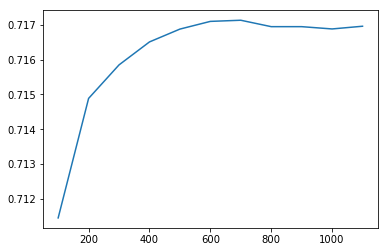

In [77]:
plt.plot(range(100, 1200, 100),score)

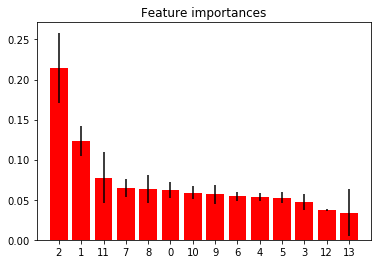

[(0, 'size'), (1, 'lat'), (2, 'lon'), (3, 'sppt'), (4, 'stmax'), (5, 'stmean'), (6, 'stmin'), (7, '1mppt'), (8, '1mtmax'), (9, '1mtmean'), (10, '1mtmin'), (11, 'doy'), (12, 'dom'), (13, 'month')]


In [78]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

print(list(zip(range(X_train.shape[1]),X_train.columns.values)))

Rest 0.929931192661
Rest [(0, 'size'), (1, 'lat'), (2, 'lon'), (3, 'sppt'), (4, 'stmax'), (5, 'stmean'), (6, 'stmin'), (7, '1mppt'), (8, '1mtmax'), (9, '1mtmean'), (10, '1mtmin'), (11, 'doy'), (12, 'dom'), (13, 'month')]


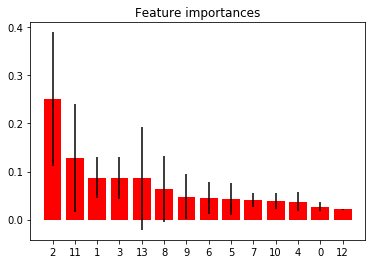

Rest 0.839285714286
Rest [(0, 'size'), (1, 'lat'), (2, 'lon'), (3, 'sppt'), (4, 'stmax'), (5, 'stmean'), (6, 'stmin'), (7, '1mppt'), (8, '1mtmax'), (9, '1mtmean'), (10, '1mtmin'), (11, 'doy'), (12, 'dom'), (13, 'month')]


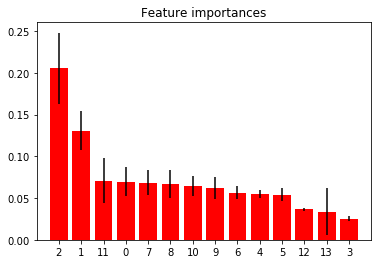

Rest 0.880860910878
Rest [(0, 'size'), (1, 'lat'), (2, 'lon'), (3, 'sppt'), (4, 'stmax'), (5, 'stmean'), (6, 'stmin'), (7, '1mppt'), (8, '1mtmax'), (9, '1mtmean'), (10, '1mtmin'), (11, 'doy'), (12, 'dom'), (13, 'month')]


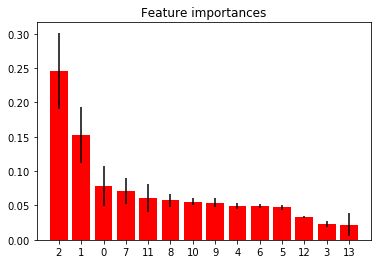

Rest 0.79880406291
Rest [(0, 'size'), (1, 'lat'), (2, 'lon'), (3, 'sppt'), (4, 'stmax'), (5, 'stmean'), (6, 'stmin'), (7, '1mppt'), (8, '1mtmax'), (9, '1mtmean'), (10, '1mtmin'), (11, 'doy'), (12, 'dom'), (13, 'month')]


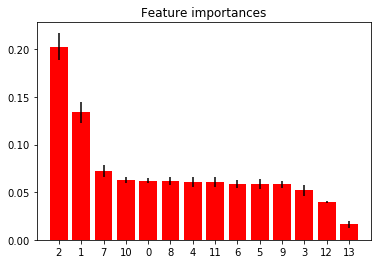

In [80]:
# Try to distinguish for each classes:

for i in ['Lightning','Debris Burning','Arson','Other']:
    s = {'Lightning','Debris Burning','Arson','Other'}
    s.remove(i)
    Y = y_train.replace(dict.fromkeys(s, 'Rest'))
    
    tmp = compute_class_weight("balanced", [i,'Rest'], Y)
    class_weight = {}
    for j, i in enumerate([i,'Rest']):
        class_weight[i] = tmp[j]

    clf = rfc(n_estimators=600, oob_score=True,n_jobs=-1, class_weight=class_weight,
                 warm_start=False)
    sc = clf.fit(X_train,Y).oob_score_

    print(i, sc)
    
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    print(i, list(zip(range(X_train.shape[1]),X_train.columns.values)))
    plt.show()

Latitude and longitude are the main predictor. For lightning, doy is a good predictor.

I don't understand why i is 'Rest'. Hopefully it was really ['Lightning','Debris Burning','Arson','Other']. The large difference in scores seems to indicate it worked.

Lightning as the best scores, which is normal since it is more related to weather than the other choices.

In [81]:
# Create new feature

# 3 months, need to reduce the df.
df['tarray'] = tarray
df['xybinarray'] = xybinarray
df = df[(df['stime']>pd.to_datetime('1992-03-31'))].copy()
tarray = df['tarray'].values
xybinarray = df['xybinarray'].values

df['3mppt'] = df['sppt']
df['3mtmax'] = df['stmax']
df['3mtmean'] = df['stmean']
df['3mtmin'] = df['stmin']
for i in range(1,90):
    df['3mppt'] += weatherData[tarray-i, xybinarray,0]
    df['3mtmax'] += weatherData[tarray-i, xybinarray,1]
    df['3mtmean'] += weatherData[tarray-i, xybinarray,2]
    df['3mtmin'] += weatherData[tarray-i, xybinarray,3]   
df['3mtmax'] /= 90
df['3mtmean'] /= 90
df['3mtmin'] /= 90

# 1 week
df['1wppt'] = df['sppt']
df['1wtmax'] = df['stmax']
df['1wtmean'] = df['stmean']
df['1wtmin'] = df['stmin']
for i in range(1,7):
    df['1wppt'] += weatherData[tarray-i, xybinarray,0]
    df['1wtmax'] += weatherData[tarray-i, xybinarray,1]
    df['1wtmean'] += weatherData[tarray-i, xybinarray,2]
    df['1wtmin'] += weatherData[tarray-i, xybinarray,3]   
df['1wtmax'] /= 7
df['1wtmean'] /= 7
df['1wtmin'] /= 7

# 1 day
df['1dppt'] = weatherData[tarray-1, xybinarray,0]
df['1dtmax'] = weatherData[tarray-1, xybinarray,1]
df['1dtmean'] = weatherData[tarray-1, xybinarray,2]
df['1dtmin'] = weatherData[tarray-1, xybinarray,3]

train_df = (df.drop('cause',axis=1).drop('causecode',axis=1).drop('stime',axis=1).
            drop('etime',axis=1)).drop('tarray',axis=1).drop('xybinarray',axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    train_df, df['causecode'], test_size=0.2)

Rest 0.926635722007
Rest [(0, 'size'), (1, 'lat'), (2, 'lon'), (3, 'sppt'), (4, 'stmax'), (5, 'stmean'), (6, 'stmin'), (7, '1mppt'), (8, '1mtmax'), (9, '1mtmean'), (10, '1mtmin'), (11, 'doy'), (12, 'dom'), (13, 'month'), (14, '3mppt'), (15, '3mtmax'), (16, '3mtmean'), (17, '3mtmin'), (18, '1wppt'), (19, '1wtmax'), (20, '1wtmean'), (21, '1wtmin'), (22, '1dppt'), (23, '1dtmax'), (24, '1dtmean'), (25, '1dtmin')]


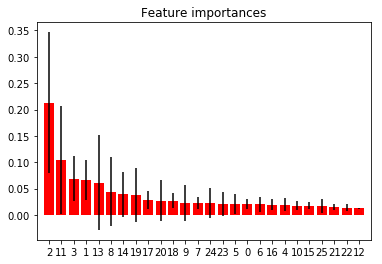

Rest 0.839121680337
Rest [(0, 'size'), (1, 'lat'), (2, 'lon'), (3, 'sppt'), (4, 'stmax'), (5, 'stmean'), (6, 'stmin'), (7, '1mppt'), (8, '1mtmax'), (9, '1mtmean'), (10, '1mtmin'), (11, 'doy'), (12, 'dom'), (13, 'month'), (14, '3mppt'), (15, '3mtmax'), (16, '3mtmean'), (17, '3mtmin'), (18, '1wppt'), (19, '1wtmax'), (20, '1wtmean'), (21, '1wtmin'), (22, '1dppt'), (23, '1dtmax'), (24, '1dtmean'), (25, '1dtmin')]


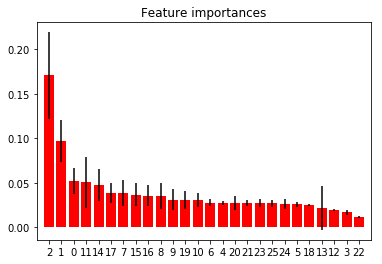

Rest 0.880506983743
Rest [(0, 'size'), (1, 'lat'), (2, 'lon'), (3, 'sppt'), (4, 'stmax'), (5, 'stmean'), (6, 'stmin'), (7, '1mppt'), (8, '1mtmax'), (9, '1mtmean'), (10, '1mtmin'), (11, 'doy'), (12, 'dom'), (13, 'month'), (14, '3mppt'), (15, '3mtmax'), (16, '3mtmean'), (17, '3mtmin'), (18, '1wppt'), (19, '1wtmax'), (20, '1wtmean'), (21, '1wtmin'), (22, '1dppt'), (23, '1dtmax'), (24, '1dtmean'), (25, '1dtmin')]


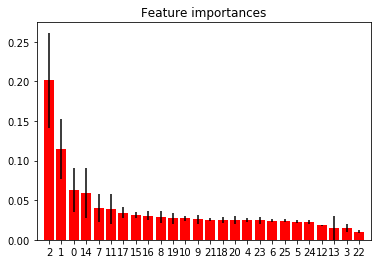

Rest 0.794769080774
Rest [(0, 'size'), (1, 'lat'), (2, 'lon'), (3, 'sppt'), (4, 'stmax'), (5, 'stmean'), (6, 'stmin'), (7, '1mppt'), (8, '1mtmax'), (9, '1mtmean'), (10, '1mtmin'), (11, 'doy'), (12, 'dom'), (13, 'month'), (14, '3mppt'), (15, '3mtmax'), (16, '3mtmean'), (17, '3mtmin'), (18, '1wppt'), (19, '1wtmax'), (20, '1wtmean'), (21, '1wtmin'), (22, '1dppt'), (23, '1dtmax'), (24, '1dtmean'), (25, '1dtmin')]


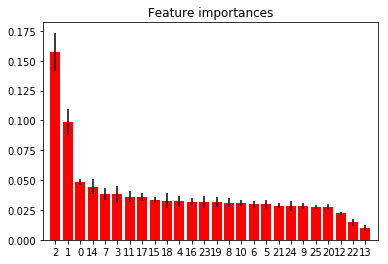

In [82]:
for i in ['Lightning','Debris Burning','Arson','Other']:
    s = {'Lightning','Debris Burning','Arson','Other'}
    s.remove(i)
    Y = y_train.replace(dict.fromkeys(s, 'Rest'))
    
    tmp = compute_class_weight("balanced", [i,'Rest'], Y)
    class_weight = {}
    for j, i in enumerate([i,'Rest']):
        class_weight[i] = tmp[j]

    clf = rfc(n_estimators=600, oob_score=True,n_jobs=-1, class_weight=class_weight,
                 warm_start=False)
    sc = clf.fit(X_train,Y).oob_score_

    print(i, sc)
    
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    print(i, list(zip(range(X_train.shape[1]),X_train.columns.values)))
    plt.show()